# Semi-supervised Learning with Deep Generative Models

https://arxiv.org/abs/1406.5298

In [1]:
using Flux
using CuArrays
using Plots
using Plots.PlotMeasures
using Distributions

CuArrays.allowscalar(false)

pyplot()

┌ Warning: Incompatibility detected between CUDA and LLVM 8.0+; disabling debug info emission for CUDA kernels
└ @ CUDAnative /home/cavani/Workspace/julia-abc/software/julia-env/packages/CUDAnative/hfulr/src/CUDAnative.jl:114


Plots.PyPlotBackend()

## MNIST Dataset

In [2]:
import Flux: onehot
import Base.Iterators: partition

function load_mnist(split_name)
    mnist = Flux.Data.MNIST
    
    images = mnist.images(split_name) # Array with N images of 28x28 8-bits gray
    labels = mnist.labels(split_name) # Array with N labels scalar 0-9
    
    return (images=images, labels=labels)
end

function sample(data, size=10)
    indices = rand(1:length(data.images), 10)
    images = data.images[indices]
    labels = data.labels[indices]
    return (images=images, labels=labels)
end

function sample_classes(data, sample_size_per_class=10)
    class_vector = sort(unique(data.labels))
    samples = map(class_vector) do label
        label_indices = findall(==(label), data.labels)
        sample_indices = rand(label_indices, sample_size_per_class)
        images = data.images[sample_indices]
        images
    end
    return samples
end

plot_digit(image, label) = plot(image, xlabel=(label !== nothing ? "Label $(label)" : ""),
                                guidefontsize=8, legend=false, margin=0mm, link=:both,
                                ticks=nothing, border=:none)
function plot_digits(images, labels=nothing; size=(800, 100), layout=(1, length(images)))
    plots = map(1:prod(layout)) do i
        image = images[i]
        label = labels !== nothing ? labels[i] : nothing
        plot_digit(image, label)
    end
    plot(plots..., layout=layout, size=size, bg_color="black", fg_color="white")
end

function compute_num_channels(image)
    color_type = eltype(image)
    if color_type <: Gray
        return 1
    elseif color_type <: RGB
        return 3
    else
        error("Unknown color type: $(color_type)")
    end
end

function make_whcn_format(images)
    width, height = size(images[1])
    num_channels = compute_num_channels(images[1])
    batch_size = length(images)
    @assert num_channels == 1 # only Gray -> Foloat32 supported

    images_tensor = Array{Float32, 4}(undef, width, height, num_channels, batch_size)
    for (batch_index, image) in enumerate(images)
        images_tensor[:, :, :, batch_index] = Float32.(reshape(image, width, height, num_channels))
    end
    return images_tensor
end

function make_onehot_format(labels, class_vector)
    num_labels = length(class_vector)
    batch_size = length(labels)
    
    labels_tensor = Array{Float32, 2}(undef, num_labels, batch_size)
    for (batch_index, label) in enumerate(labels)
        labels_tensor[:, batch_index] = Float32.(onehot(label, class_vector))
    end
    return labels_tensor
end

function make_batch(images, labels)
    X = make_whcn_format(images)
    y = make_onehot_format(labels, 0:9)
    return (X=X, y=y)
end

function make_dataset(images, labels; batch_size)
    batch_size == 0 && return make_batch(images, labels)
    
    num_examples = length(images)
    num_batches = ceil(Int, num_examples / batch_size)
    batch_indices = partition(1:num_examples, batch_size)
    batches = map(batch_indices) do indices
        make_batch(images[indices], labels[indices])
    end
    return batches
end

make_dataset (generic function with 1 method)

In [3]:
train_data = load_mnist(:train)
test_data = load_mnist(:test)

dataset_train = make_dataset(train_data...; batch_size=256)
dataset_test = make_dataset(test_data...; batch_size=0);

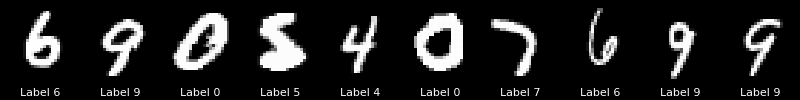

In [4]:
train_sample = sample(train_data)
plot_digits(train_sample...)

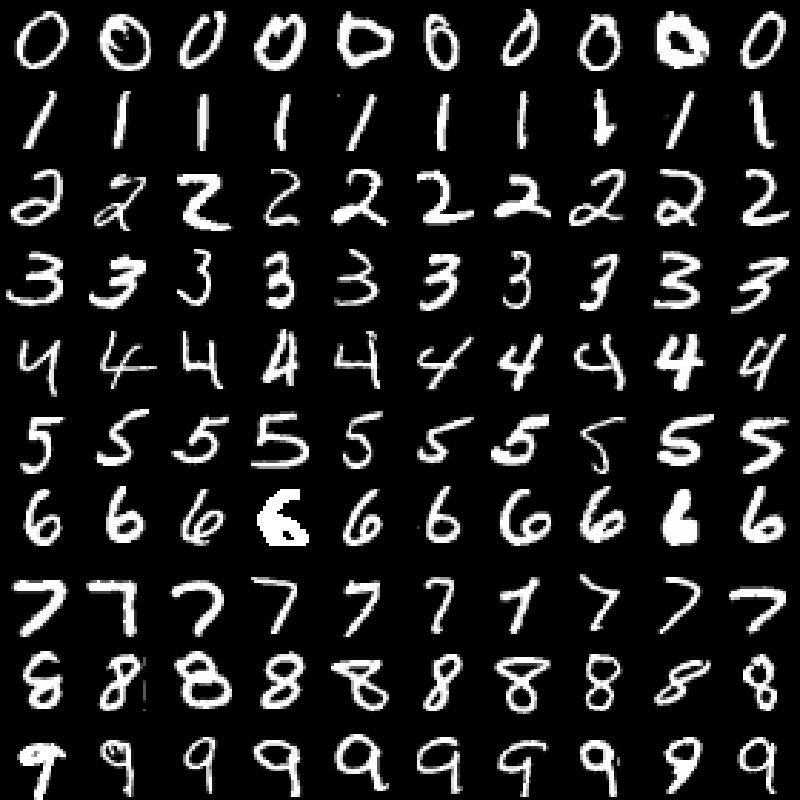

In [5]:
train_sample2 = sample_classes(train_data)
plot_digits(vcat(train_sample2...); size=(800, 800), layout=(10, 10))

In [6]:
println("Train\n")
println("Number of batches   : ", length(dataset_train))
println("First batch X shape : ", size(dataset_train[1].X))
println("First batch y shape : ", size(dataset_train[1].y))
println("Last batch X shape  : ", size(dataset_train[end].X))
println("Last batch y shape  : ", size(dataset_train[end].y))
println()
println("Test\n")
println("X shape             : ", size(dataset_test.X))
println("y shape             : ", size(dataset_test.y))

Train

Number of batches   : 235
First batch X shape : (28, 28, 1, 256)
First batch y shape : (10, 256)
Last batch X shape  : (28, 28, 1, 96)
Last batch y shape  : (10, 96)

Test

X shape             : (28, 28, 1, 10000)
y shape             : (10, 10000)


In [7]:
using Flux.Data.MNIST

# Load data, binarise it, and partition into mini-batches of M.
X = float.(hcat(vec.(MNIST.images())...)) .> 0.5
N, M = size(X, 2), 100
data = [X[:,i] for i in Iterators.partition(1:N,M)];

size(data)

(600,)

In [8]:
# Extend distributions slightly to have a numerically stable logpdf for `p` close to 1 or 0.
import Distributions: logpdf
logpdf(b::Bernoulli, y::Bool) = y * log(b.p + eps(Float32)) + (1f0 - y) * log(1 - b.p + eps(Float32))

logpdf (generic function with 64 methods)

In [9]:
################################# Define Model #################################

# Latent dimensionality, # hidden units.
Dz, Dh = 5, 500

# Components of recognition model / "encoder" MLP.
A, μ, logσ = Dense(28^2, Dh, tanh), Dense(Dh, Dz), Dense(Dh, Dz)
g(X) = (h = A(X); (μ(h), logσ(h)))
z(μ, logσ) = μ + exp(logσ) * randn(Float32)

# Generative model / "decoder" MLP.
f = Chain(Dense(Dz, Dh, tanh), Dense(Dh, 28^2, σ))

Chain(Dense(5, 500, tanh), Dense(500, 784, σ))

In [10]:
####################### Define ways of doing things with the model. #######################

# KL-divergence between approximation posterior and N(0, 1) prior.
kl_q_p(μ, logσ) = 0.5f0 * sum(exp.(2f0 .* logσ) + μ.^2 .- 1f0 .- (2 .* logσ))

# logp(x|z) - conditional probability of data given latents.
logp_x_z(x, z) = sum(logpdf.(Bernoulli.(f(z)), x))

# Monte Carlo estimator of mean ELBO using M samples.
L̄(X) = ((μ̂, logσ̂) = g(X); (logp_x_z(X, z.(μ̂, logσ̂)) - kl_q_p(μ̂, logσ̂)) * 1 // M)

loss(X) = -L̄(X) + 0.01f0 * sum(x->sum(x.^2), params(f))

# Sample from the learned model.
modelsample() = rand.(Bernoulli.(f(z.(zeros(Dz), zeros(Dz)))))

modelsample (generic function with 1 method)

In [11]:
################################# Learn Parameters ##############################

import Flux: throttle, params

evalcb = throttle(() -> @show(-L̄(X[:, rand(1:N, M)])), 30)
opt = ADAM()
ps = params(A, μ, logσ, f)

for i = 1:10
  @info "Epoch $i"
  Flux.train!(loss, ps, zip(data), opt, cb=evalcb)
end

┌ Info: Epoch 1
└ @ Main In[11]:10


-(L̄(X[:, rand(1:N, M)])) = 546.39795f0
-(L̄(X[:, rand(1:N, M)])) = 227.1756f0
-(L̄(X[:, rand(1:N, M)])) = 200.3289f0
-(L̄(X[:, rand(1:N, M)])) = 184.23395f0
-(L̄(X[:, rand(1:N, M)])) = 175.02106f0
-(L̄(X[:, rand(1:N, M)])) = 175.13611f0
-(L̄(X[:, rand(1:N, M)])) = 172.91798f0
-(L̄(X[:, rand(1:N, M)])) = 164.14784f0
-(L̄(X[:, rand(1:N, M)])) = 157.91588f0
-(L̄(X[:, rand(1:N, M)])) = 159.08096f0
-(L̄(X[:, rand(1:N, M)])) = 165.71664f0
-(L̄(X[:, rand(1:N, M)])) = 167.04677f0
-(L̄(X[:, rand(1:N, M)])) = 169.85309f0
-(L̄(X[:, rand(1:N, M)])) = 170.25093f0
-(L̄(X[:, rand(1:N, M)])) = 164.0806f0
-(L̄(X[:, rand(1:N, M)])) = 164.69713f0
-(L̄(X[:, rand(1:N, M)])) = 157.29361f0
-(L̄(X[:, rand(1:N, M)])) = 158.56749f0
-(L̄(X[:, rand(1:N, M)])) = 164.19496f0
-(L̄(X[:, rand(1:N, M)])) = 155.68983f0
-(L̄(X[:, rand(1:N, M)])) = 164.932f0
-(L̄(X[:, rand(1:N, M)])) = 163.09901f0


┌ Info: Epoch 2
└ @ Main In[11]:10


-(L̄(X[:, rand(1:N, M)])) = 161.7964f0
-(L̄(X[:, rand(1:N, M)])) = 158.42014f0
-(L̄(X[:, rand(1:N, M)])) = 157.73834f0
-(L̄(X[:, rand(1:N, M)])) = 161.04465f0
-(L̄(X[:, rand(1:N, M)])) = 150.53601f0
-(L̄(X[:, rand(1:N, M)])) = 149.11383f0
-(L̄(X[:, rand(1:N, M)])) = 155.58682f0
-(L̄(X[:, rand(1:N, M)])) = 149.78912f0
-(L̄(X[:, rand(1:N, M)])) = 158.66731f0
-(L̄(X[:, rand(1:N, M)])) = 153.69214f0
-(L̄(X[:, rand(1:N, M)])) = 156.45015f0
-(L̄(X[:, rand(1:N, M)])) = 148.3454f0
-(L̄(X[:, rand(1:N, M)])) = 158.84273f0
-(L̄(X[:, rand(1:N, M)])) = 156.00694f0
-(L̄(X[:, rand(1:N, M)])) = 147.71986f0
-(L̄(X[:, rand(1:N, M)])) = 147.79303f0
-(L̄(X[:, rand(1:N, M)])) = 155.41464f0
-(L̄(X[:, rand(1:N, M)])) = 154.3278f0
-(L̄(X[:, rand(1:N, M)])) = 152.2415f0
-(L̄(X[:, rand(1:N, M)])) = 144.2533f0
-(L̄(X[:, rand(1:N, M)])) = 147.98378f0


┌ Info: Epoch 3
└ @ Main In[11]:10


-(L̄(X[:, rand(1:N, M)])) = 150.78911f0
-(L̄(X[:, rand(1:N, M)])) = 150.40053f0
-(L̄(X[:, rand(1:N, M)])) = 148.0711f0
-(L̄(X[:, rand(1:N, M)])) = 143.02232f0
-(L̄(X[:, rand(1:N, M)])) = 143.22603f0
-(L̄(X[:, rand(1:N, M)])) = 147.62f0
-(L̄(X[:, rand(1:N, M)])) = 149.58177f0
-(L̄(X[:, rand(1:N, M)])) = 138.55713f0
-(L̄(X[:, rand(1:N, M)])) = 141.45386f0
-(L̄(X[:, rand(1:N, M)])) = 144.4152f0
-(L̄(X[:, rand(1:N, M)])) = 146.7241f0
-(L̄(X[:, rand(1:N, M)])) = 141.68684f0
-(L̄(X[:, rand(1:N, M)])) = 147.10858f0
-(L̄(X[:, rand(1:N, M)])) = 140.25873f0
-(L̄(X[:, rand(1:N, M)])) = 150.6041f0
-(L̄(X[:, rand(1:N, M)])) = 139.96092f0
-(L̄(X[:, rand(1:N, M)])) = 135.61107f0
-(L̄(X[:, rand(1:N, M)])) = 135.84494f0
-(L̄(X[:, rand(1:N, M)])) = 150.40886f0
-(L̄(X[:, rand(1:N, M)])) = 143.63808f0
-(L̄(X[:, rand(1:N, M)])) = 140.55032f0
-(L̄(X[:, rand(1:N, M)])) = 141.96881f0


┌ Info: Epoch 4
└ @ Main In[11]:10


-(L̄(X[:, rand(1:N, M)])) = 148.09752f0
-(L̄(X[:, rand(1:N, M)])) = 140.97762f0
-(L̄(X[:, rand(1:N, M)])) = 140.03795f0
-(L̄(X[:, rand(1:N, M)])) = 140.87846f0
-(L̄(X[:, rand(1:N, M)])) = 140.24188f0
-(L̄(X[:, rand(1:N, M)])) = 141.63707f0
-(L̄(X[:, rand(1:N, M)])) = 140.93681f0
-(L̄(X[:, rand(1:N, M)])) = 137.61804f0
-(L̄(X[:, rand(1:N, M)])) = 143.02423f0
-(L̄(X[:, rand(1:N, M)])) = 141.17378f0
-(L̄(X[:, rand(1:N, M)])) = 139.6372f0
-(L̄(X[:, rand(1:N, M)])) = 151.19818f0
-(L̄(X[:, rand(1:N, M)])) = 147.82466f0
-(L̄(X[:, rand(1:N, M)])) = 140.76704f0
-(L̄(X[:, rand(1:N, M)])) = 137.40875f0
-(L̄(X[:, rand(1:N, M)])) = 141.81631f0
-(L̄(X[:, rand(1:N, M)])) = 136.89937f0
-(L̄(X[:, rand(1:N, M)])) = 135.52982f0
-(L̄(X[:, rand(1:N, M)])) = 143.58784f0
-(L̄(X[:, rand(1:N, M)])) = 141.1614f0
-(L̄(X[:, rand(1:N, M)])) = 137.12222f0


┌ Info: Epoch 5
└ @ Main In[11]:10


-(L̄(X[:, rand(1:N, M)])) = 136.29504f0
-(L̄(X[:, rand(1:N, M)])) = 140.62949f0
-(L̄(X[:, rand(1:N, M)])) = 142.76277f0
-(L̄(X[:, rand(1:N, M)])) = 132.95894f0
-(L̄(X[:, rand(1:N, M)])) = 138.18732f0
-(L̄(X[:, rand(1:N, M)])) = 133.91318f0
-(L̄(X[:, rand(1:N, M)])) = 147.14131f0
-(L̄(X[:, rand(1:N, M)])) = 135.66016f0
-(L̄(X[:, rand(1:N, M)])) = 139.463f0
-(L̄(X[:, rand(1:N, M)])) = 134.74434f0
-(L̄(X[:, rand(1:N, M)])) = 139.08719f0
-(L̄(X[:, rand(1:N, M)])) = 132.03351f0
-(L̄(X[:, rand(1:N, M)])) = 134.89825f0
-(L̄(X[:, rand(1:N, M)])) = 133.69337f0
-(L̄(X[:, rand(1:N, M)])) = 137.01376f0
-(L̄(X[:, rand(1:N, M)])) = 139.23335f0
-(L̄(X[:, rand(1:N, M)])) = 133.46332f0
-(L̄(X[:, rand(1:N, M)])) = 128.3824f0
-(L̄(X[:, rand(1:N, M)])) = 141.96147f0
-(L̄(X[:, rand(1:N, M)])) = 133.5388f0
-(L̄(X[:, rand(1:N, M)])) = 128.4766f0
-(L̄(X[:, rand(1:N, M)])) = 145.44046f0


┌ Info: Epoch 6
└ @ Main In[11]:10


-(L̄(X[:, rand(1:N, M)])) = 143.24666f0
-(L̄(X[:, rand(1:N, M)])) = 136.45232f0
-(L̄(X[:, rand(1:N, M)])) = 134.17308f0
-(L̄(X[:, rand(1:N, M)])) = 139.41304f0
-(L̄(X[:, rand(1:N, M)])) = 134.81432f0
-(L̄(X[:, rand(1:N, M)])) = 134.52553f0
-(L̄(X[:, rand(1:N, M)])) = 138.31445f0
-(L̄(X[:, rand(1:N, M)])) = 131.86227f0
-(L̄(X[:, rand(1:N, M)])) = 142.17078f0
-(L̄(X[:, rand(1:N, M)])) = 128.93007f0
-(L̄(X[:, rand(1:N, M)])) = 130.44954f0
-(L̄(X[:, rand(1:N, M)])) = 140.7938f0
-(L̄(X[:, rand(1:N, M)])) = 136.95753f0
-(L̄(X[:, rand(1:N, M)])) = 131.07568f0
-(L̄(X[:, rand(1:N, M)])) = 133.82716f0
-(L̄(X[:, rand(1:N, M)])) = 132.54346f0
-(L̄(X[:, rand(1:N, M)])) = 136.41928f0
-(L̄(X[:, rand(1:N, M)])) = 131.02821f0
-(L̄(X[:, rand(1:N, M)])) = 135.89444f0
-(L̄(X[:, rand(1:N, M)])) = 132.3879f0
-(L̄(X[:, rand(1:N, M)])) = 135.90794f0


┌ Info: Epoch 7
└ @ Main In[11]:10


-(L̄(X[:, rand(1:N, M)])) = 129.62872f0
-(L̄(X[:, rand(1:N, M)])) = 132.99841f0
-(L̄(X[:, rand(1:N, M)])) = 132.92554f0
-(L̄(X[:, rand(1:N, M)])) = 133.98387f0
-(L̄(X[:, rand(1:N, M)])) = 130.754f0
-(L̄(X[:, rand(1:N, M)])) = 139.09769f0
-(L̄(X[:, rand(1:N, M)])) = 137.1508f0
-(L̄(X[:, rand(1:N, M)])) = 136.05797f0
-(L̄(X[:, rand(1:N, M)])) = 140.96634f0
-(L̄(X[:, rand(1:N, M)])) = 135.83765f0
-(L̄(X[:, rand(1:N, M)])) = 136.60655f0
-(L̄(X[:, rand(1:N, M)])) = 137.08955f0
-(L̄(X[:, rand(1:N, M)])) = 131.89967f0
-(L̄(X[:, rand(1:N, M)])) = 139.25296f0
-(L̄(X[:, rand(1:N, M)])) = 134.9593f0
-(L̄(X[:, rand(1:N, M)])) = 136.0391f0
-(L̄(X[:, rand(1:N, M)])) = 134.08746f0
-(L̄(X[:, rand(1:N, M)])) = 134.50781f0
-(L̄(X[:, rand(1:N, M)])) = 135.59076f0
-(L̄(X[:, rand(1:N, M)])) = 128.75221f0
-(L̄(X[:, rand(1:N, M)])) = 131.21825f0
-(L̄(X[:, rand(1:N, M)])) = 134.99278f0


┌ Info: Epoch 8
└ @ Main In[11]:10


-(L̄(X[:, rand(1:N, M)])) = 137.2878f0
-(L̄(X[:, rand(1:N, M)])) = 130.9691f0
-(L̄(X[:, rand(1:N, M)])) = 128.95251f0
-(L̄(X[:, rand(1:N, M)])) = 135.41281f0
-(L̄(X[:, rand(1:N, M)])) = 136.48138f0
-(L̄(X[:, rand(1:N, M)])) = 136.02043f0
-(L̄(X[:, rand(1:N, M)])) = 130.83928f0
-(L̄(X[:, rand(1:N, M)])) = 130.11935f0
-(L̄(X[:, rand(1:N, M)])) = 129.94324f0
-(L̄(X[:, rand(1:N, M)])) = 134.99316f0
-(L̄(X[:, rand(1:N, M)])) = 132.3436f0
-(L̄(X[:, rand(1:N, M)])) = 134.49493f0
-(L̄(X[:, rand(1:N, M)])) = 137.28267f0
-(L̄(X[:, rand(1:N, M)])) = 135.35968f0
-(L̄(X[:, rand(1:N, M)])) = 131.98692f0
-(L̄(X[:, rand(1:N, M)])) = 130.13567f0
-(L̄(X[:, rand(1:N, M)])) = 125.867645f0
-(L̄(X[:, rand(1:N, M)])) = 128.80952f0
-(L̄(X[:, rand(1:N, M)])) = 130.84058f0
-(L̄(X[:, rand(1:N, M)])) = 133.6727f0
-(L̄(X[:, rand(1:N, M)])) = 127.07953f0


┌ Info: Epoch 9
└ @ Main In[11]:10


-(L̄(X[:, rand(1:N, M)])) = 133.96721f0
-(L̄(X[:, rand(1:N, M)])) = 137.74727f0
-(L̄(X[:, rand(1:N, M)])) = 129.56134f0
-(L̄(X[:, rand(1:N, M)])) = 124.4941f0
-(L̄(X[:, rand(1:N, M)])) = 128.75085f0
-(L̄(X[:, rand(1:N, M)])) = 127.760056f0
-(L̄(X[:, rand(1:N, M)])) = 140.60663f0
-(L̄(X[:, rand(1:N, M)])) = 136.91733f0
-(L̄(X[:, rand(1:N, M)])) = 130.42274f0
-(L̄(X[:, rand(1:N, M)])) = 131.31064f0
-(L̄(X[:, rand(1:N, M)])) = 126.22201f0
-(L̄(X[:, rand(1:N, M)])) = 129.01f0
-(L̄(X[:, rand(1:N, M)])) = 128.76756f0
-(L̄(X[:, rand(1:N, M)])) = 130.4334f0
-(L̄(X[:, rand(1:N, M)])) = 131.81662f0
-(L̄(X[:, rand(1:N, M)])) = 134.84457f0
-(L̄(X[:, rand(1:N, M)])) = 122.79034f0
-(L̄(X[:, rand(1:N, M)])) = 127.40986f0
-(L̄(X[:, rand(1:N, M)])) = 133.64563f0
-(L̄(X[:, rand(1:N, M)])) = 130.46982f0
-(L̄(X[:, rand(1:N, M)])) = 131.17245f0


┌ Info: Epoch 10
└ @ Main In[11]:10


-(L̄(X[:, rand(1:N, M)])) = 135.11125f0
-(L̄(X[:, rand(1:N, M)])) = 129.49095f0
-(L̄(X[:, rand(1:N, M)])) = 124.88943f0
-(L̄(X[:, rand(1:N, M)])) = 134.06395f0
-(L̄(X[:, rand(1:N, M)])) = 128.41093f0
-(L̄(X[:, rand(1:N, M)])) = 136.49153f0
-(L̄(X[:, rand(1:N, M)])) = 132.89087f0
-(L̄(X[:, rand(1:N, M)])) = 124.82368f0
-(L̄(X[:, rand(1:N, M)])) = 135.21361f0
-(L̄(X[:, rand(1:N, M)])) = 135.23021f0
-(L̄(X[:, rand(1:N, M)])) = 131.17613f0
-(L̄(X[:, rand(1:N, M)])) = 128.2076f0
-(L̄(X[:, rand(1:N, M)])) = 127.59591f0
-(L̄(X[:, rand(1:N, M)])) = 128.34283f0
-(L̄(X[:, rand(1:N, M)])) = 134.24599f0
-(L̄(X[:, rand(1:N, M)])) = 134.24115f0
-(L̄(X[:, rand(1:N, M)])) = 126.963356f0
-(L̄(X[:, rand(1:N, M)])) = 131.6481f0
-(L̄(X[:, rand(1:N, M)])) = 129.58548f0
-(L̄(X[:, rand(1:N, M)])) = 124.50628f0
-(L̄(X[:, rand(1:N, M)])) = 127.93744f0
-(L̄(X[:, rand(1:N, M)])) = 128.7902f0


In [13]:
################################# Sample Output ##############################

using Images

img(x) = Gray.(reshape(x, 28, 28))

sample_image = hcat(img.([modelsample() for i = 1:10])...)
save("sample.png", sample_image)